### Amir Kooshan Fattah Hesari - 401102191
#### Homework 4 - DDPG and SAC algorithms

In [1]:
%%capture
!pip install mujoco==2.3.3

In [2]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


## **Importing Required Libraries**

This cell imports essential libraries for implementing and visualizing Deep Deterministic Policy Gradient (DDPG) and Soft Actor-Critic (SAC). The key components include:


In [3]:
from   torch.optim import Adam
import torch
import torch.nn as nn
import torch.nn.functional as F
from   torch.distributions import Normal
import random
import numpy as np
import logging
import matplotlib
import matplotlib.pyplot as plt
import imageio
from IPython.display import HTML
from base64 import b64encode
import gymnasium as gym



is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display



logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Logging, Visualization, and Video Playback Functions**


In [5]:
def plot_rewards(sum_of_rewards, show_result=None , bove = None,dn = None):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result is not None:
        plt.title(f'{show_result}')
    else:
        plt.clf()
        plt.title('Training...')
    if bove is not None:
        plt.xlabel(f'{bove}')
    else:
        plt.xlabel('Episode')
    if dn is not None:
        plt.xlabel(f'{dn}')
    else:
        plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

## **Replay Memory for Experience Replay**

This class implements a **Replay Buffer**, a crucial component in off-policy reinforcement learning algorithms like DDPG and SAC. The buffer stores past experiences and allows the agent to sample them randomly, breaking correlation between consecutive samples and improving learning stability.

In [6]:
class ReplayMemory:
    def __init__(self, capacity, seed):
        random.seed(seed)
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

## **Neural Networks for DDPG and SAC**

This cell defines key neural networks used in **Deep Deterministic Policy Gradient (DDPG)** and **Soft Actor-Critic (SAC)** algorithms.


- **`GaussianPolicy`**: A stochastic policy for SAC, using Gaussian action sampling.
- **`DeterministicPolicy`**: A deterministic actor for DDPG, applying action bounds.

In [7]:
# Initialize Policy weights
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)


class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_dim):
        super(ValueNetwork, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class QNetwork(nn.Module):
    # Todo12
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(QNetwork, self).__init__()
        # TODO 1 -> Define two separate Q-networks (Q1 and Q2) for twin Q-learning.
        self.Q1 = nn.Sequential(
            nn.Linear(num_inputs + num_actions , hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim , hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim ,1)
        )
        self.Q2 = nn.Sequential(
            nn.Linear(num_inputs + num_actions , hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim , hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim , 1)
        )
        pass 
        self.apply(weights_init_)
    def forward(self, state, action):
        # TODO 2 -> Concatenate state and action as input and compute Q-values for both Q-networks.
        xu = torch.cat([state, action], dim=1)
        Q1 = self.Q1(xu)
        Q2 = self.Q2(xu)
        return Q1, Q2
LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6
class GaussianPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space):
        super(GaussianPolicy, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean_linear = nn.Linear(hidden_dim, num_actions)
        # State-independent log_std (parameter)
        self.log_std = nn.Parameter(torch.zeros(num_actions),requires_grad = True)
        self.action_scale = torch.FloatTensor(
            (action_space.high - action_space.low) / 2.)
        self.action_bias = torch.FloatTensor(
            (action_space.high + action_space.low) / 2.)
        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = self.mean_linear(x)
        # Same log_std for all states
        log_std = torch.clamp(self.log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        
        # TODO 4: Reparameterization trick and apply bounds
        x_t = normal.rsample()
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean
class DeterministicPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space=None):
        super(DeterministicPolicy, self).__init__()
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean = nn.Linear(hidden_dim, num_actions)
        self.noise = torch.Tensor(num_actions)

        self.apply(weights_init_)

        # TODO 5: Action scaling and shifting
        self.action_scale = torch.FloatTensor(
            (action_space.high - action_space.low) / 2.)
        self.action_bias = torch.FloatTensor(
            (action_space.high + action_space.low) / 2.)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = torch.tanh(self.mean(x)) * self.action_scale + self.action_bias
        return mean

    def sample(self, state):
        mean = self.forward(state)
        # TODO 6: Add noise for exploration
        noise = self.noise.normal_(0., std=0.1)
        action = mean + noise
        action = torch.clamp(action, -self.action_scale + self.action_bias,
                                       self.action_scale + self.action_bias)
        return action, torch.tensor(0.), mean



## **Soft Actor-Critic (SAC) Implementation - Explanation of the Cell**

This cell implements the **Soft Actor-Critic (SAC) algorithm**, a state-of-the-art off-policy reinforcement learning method for continuous control. The key idea behind SAC is to maximize both the **expected reward** and the **entropy** of the policy, promoting exploration and robustness.

### **Main Components in This Cell**
1. **Hyperparameters & Configuration**  
   - The algorithm's key parameters such as **discount factor** ($\gamma$), **soft update factor** ($\tau$), and **entropy coefficient** ($\alpha$) are set from the `config` dictionary.
   - **Entropy tuning** is optionally enabled to adjust $\alpha$ dynamically.

2. **Critic (Q-Networks)**
   - Two separate **Q-networks** (`self.critic` and `self.critic_target`) estimate the action-value function.
   - Using **twin Q-learning** (two critics) reduces overestimation bias.

3. **Actor (Policy Network)**
   - **Gaussian policy** is used when `policy_type="Gaussian"`, meaning actions are sampled from a probability distribution instead of being deterministic.
   - The policy is trained to maximize both expected rewards and entropy.
   - If the deterministic version (DDPG-like) is used, entropy is ignored ($\alpha = 0$).

4. **Action Selection (`select_action`)**
   - If `evaluate=False`, actions are sampled from the stochastic policy.
   - If `evaluate=True`, deterministic actions are chosen for testing.

5. **Parameter Update (`update_parameters`)**
   - **Sample a batch** from replay memory.
   - Compute **target Q-values** using the **minimum of the two Q-networks**.
   - Update **critic networks** by minimizing Bellman loss.
   - Update **policy** using the entropy-regularized objective.
   - If entropy tuning is enabled, update **$\alpha$** using.
   - Periodically **soft update** the target Q-network.


In [8]:
class SAC(object):
    def __init__(self, num_inputs, action_space, config):

        self.gamma = config['gamma']
        self.tau = config['tau']
        self.alpha = config['alpha']

        self.policy_type = config["policy"]
        self.target_update_interval = config["target_update_interval"]
        self.automatic_entropy_tuning = config['automatic_entropy_tuning']

        self.device = torch.device("cuda" if config['cuda'] else "cpu")

        self.critic = QNetwork(num_inputs, action_space.shape[0], config['hidden_size']).to(self.device)
        self.critic_optim = Adam(self.critic.parameters(), lr=config['lr'])

        self.critic_target = QNetwork(num_inputs, action_space.shape[0], config["hidden_size"]).to(self.device)
        self.hard_update(self.critic_target, self.critic)

        if self.policy_type == "Gaussian":
            # TODO 7: Target Entropy and Automatic entropy tuning
            self.target_entropy = -np.prod(action_space.shape).item()
            self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
            self.alpha_optim = Adam([self.log_alpha], lr=config['lr'])

            self.policy = GaussianPolicy(num_inputs, action_space.shape[0], config["hidden_size"], action_space).to(self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=config["lr"])

        else:
            self.alpha = 0
            self.automatic_entropy_tuning = False
            self.policy = DeterministicPolicy(num_inputs, action_space.shape[0], config["hidden_size"], action_space).to(self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=config['lr'])

    def select_action(self, state, evaluate=False):
        state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        if evaluate is False:
            # TODO 8: Sample from stochastic policy during training
            action, _, _ = self.policy.sample(state)
        else:
            # Deterministic action for evaluation
            _, _, action = self.policy.sample(state)

        return action.detach().cpu().numpy()[0]

    def update_parameters(self, memory, batch_size, updates):
        state_batch, action_batch, reward_batch, next_state_batch, mask_batch = memory.sample(batch_size=batch_size)

        state_batch = torch.FloatTensor(state_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device).unsqueeze(1)
        mask_batch = torch.FloatTensor(mask_batch).to(self.device).unsqueeze(1)

        with torch.no_grad():
            next_state_action, next_state_log_pi, _ = self.policy.sample(next_state_batch)
            qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
            next_q_value = reward_batch + mask_batch * self.gamma * min_qf_next_target

        # TODO 9: Q-value losses
        qf1, qf2 = self.critic(state_batch, action_batch)
        qf1_loss = F.mse_loss(qf1, next_q_value)
        qf2_loss = F.mse_loss(qf2, next_q_value)
        qf_loss = qf1_loss + qf2_loss

        self.critic_optim.zero_grad()
        qf_loss.backward()
        self.critic_optim.step()

        pi, log_pi, _ = self.policy.sample(state_batch)

        # TODO 10: Policy loss with entropy term
        qf1_pi, qf2_pi = self.critic(state_batch, pi)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)
        policy_loss = ((self.alpha * log_pi) - min_qf_pi).mean()

        self.policy_optim.zero_grad()
        policy_loss.backward()
        self.policy_optim.step()

        # TODO 12: Automatic entropy tuning
        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()

            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()

            self.alpha = self.log_alpha.exp()
            alpha_tlogs = self.alpha.clone()
        else:
            alpha_loss = torch.tensor(0.).to(self.device)
            alpha_tlogs = torch.tensor(self.alpha)

        if updates % self.target_update_interval == 0:
            self.soft_update(self.critic_target, self.critic, self.tau)

        return qf1_loss.item(), qf2_loss.item(), policy_loss.item(), alpha_loss.item(), alpha_tlogs.item()

    # TODO 13: Soft update implementation
    def soft_update(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)


## **Environment Setup and Initialization for SAC**

This cell sets up the environment and initializes the components needed to train the **Soft Actor-Critic (SAC)** agent.


In [9]:
config = {
    "env_name": "HalfCheetah-v4",
    "policy": "Gaussian",
    "gamma": 0.99,
    "tau": 0.005,
    "lr": 0.0003,
    "alpha": 0.2,
    "seed":123456,
    "automatic_entropy_tuning": False,
    "batch_size": 256,
    "num_steps": 1000001,
    "hidden_size": 256,
    "updates_per_step": 1,
    "start_steps": 10000,
    "target_update_interval": 1,
    "replay_size": 1000000,
    "cuda": False,
    "eval_interval": 1,
}

# Setup environment
env = gym.make(config["env_name"])
env.action_space.seed(config["seed"])

# Set random seeds
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Initialize agent
agent = SAC(env.observation_space.shape[0], env.action_space, config)

# Initialize replay memory
memory = ReplayMemory(config["replay_size"], config["seed"])




## **Training Loop for SAC Agent**

This cell contains the **training loop** for the Soft Actor-Critic (SAC) agent. The loop runs for a set number of episodes, where in each episode, the agent interacts with the environment, collects experiences, and updates its parameters.

Episode 10, Reward: -389.26, Eval Reward: -167.07
Episode 20, Reward: -73.28, Eval Reward: -22.79
Episode 30, Reward: -7.46, Eval Reward: 373.96
Episode 40, Reward: 653.49, Eval Reward: 998.99
Episode 50, Reward: 1658.72, Eval Reward: 2219.96
Episode 60, Reward: 2030.38, Eval Reward: 2662.91
Episode 70, Reward: 2566.62, Eval Reward: 3434.62
Episode 80, Reward: 2963.97, Eval Reward: 3728.64
Episode 90, Reward: 3284.19, Eval Reward: 3910.85
Episode 100, Reward: 3703.74, Eval Reward: 4334.62
Episode 110, Reward: 3771.84, Eval Reward: 4474.83
Episode 120, Reward: 3998.70, Eval Reward: 4727.33
Episode 130, Reward: 4201.79, Eval Reward: 4928.22
Episode 140, Reward: 4232.18, Eval Reward: 5199.70
Episode 150, Reward: 4799.03, Eval Reward: 5383.77
Episode 160, Reward: 4999.39, Eval Reward: 5720.62
Episode 170, Reward: 5089.12, Eval Reward: 5634.24
Episode 180, Reward: 5239.06, Eval Reward: 5808.34
Episode 190, Reward: 5363.78, Eval Reward: 6045.68
Episode 200, Reward: 5365.43, Eval Reward: 6244

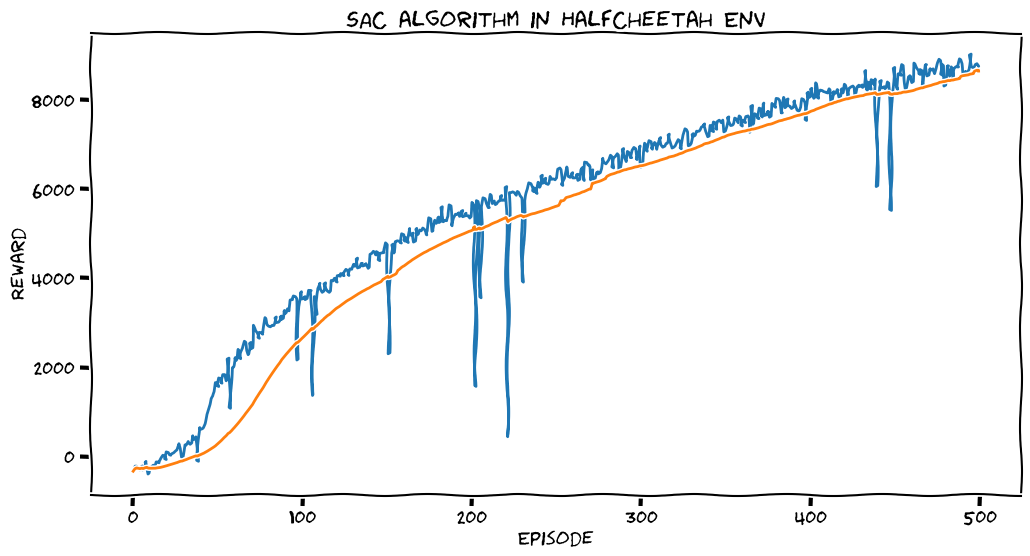

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [10]:
# Training Loop

total_numsteps = 0
updates = 0
reward_history = []
eval_reward_history = []
Max_episodes = 500
criteria = 0
max_reward = -float('inf')

for i_episode in range(1, Max_episodes + 1):
    state, _ = env.reset()
    episode_reward = 0

    for step in range(env._max_episode_steps):
        if config['start_steps'] > total_numsteps:
            action = env.action_space.sample()  # Random action initially
        else:
            action = agent.select_action(state)

        if len(memory) > config['batch_size']:
            critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, config['batch_size'], updates)
            updates += 1

        next_state, reward, done, truncated, _ = env.step(action)
        episode_reward += reward

        mask = 1 if step == env._max_episode_steps - 1 else float(not (done or truncated))
        memory.push(state, action, reward, next_state, mask)

        state = next_state
        total_numsteps += 1

        if done or truncated:
            break

    reward_history.append(episode_reward)

    # Evaluation directly after training each episode
    eval_state, _ = env.reset()
    eval_episode_reward = 0
    eval_done = False
    while not eval_done:
        eval_action = agent.select_action(eval_state, evaluate=True)
        eval_next_state, eval_reward, eval_done, eval_truncated, _ = env.step(eval_action)
        eval_episode_reward += eval_reward
        eval_state = eval_next_state
        eval_done = eval_done or eval_truncated

    eval_reward_history.append(eval_episode_reward)
    if i_episode % 10 == 0 :
        print(f"Episode {i_episode}, Reward: {episode_reward:.2f}, Eval Reward: {eval_episode_reward:.2f}")

    if eval_episode_reward > max_reward:
        max_reward = eval_episode_reward
        criteria = 0
    else:
        criteria += 1

    #if criteria >= 20:
    #    print("Early stopping criteria met")
    #    break

env.close()

# Plot both training and evaluation rewards
plot_rewards(reward_history, show_result='SAC algorithm in HalfCheetah Env')


In [11]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
state, _ = env.reset()
frames = []

total_reward = 0
# run the policy in the environment in a loop
done = False
while not done:
    frames.append(env.render())
    action  = agent.select_action(state,evaluate=True)
    next_state, reward, done, truncated, _  = env.step(action)
    state = next_state
    total_reward += reward
    done = done or truncated
env.close()
print(f'Total Reward: {total_reward}')
imageio.mimsave('./eval_SAC.mp4', frames, fps=25)
show_video('./eval_SAC.mp4')

Total Reward: 9743.303898678061


# **Initialize DDPG** 

In [12]:
# Configuration dictionary
config = {
    "env_name": "HalfCheetah-v4",
    "policy": "Deterministic",
    "gamma": 0.99,
    "tau": 0.005,
    "lr": 0.0003,
    "alpha": 0.2,
    "seed":123456,
    "automatic_entropy_tuning": False,
    "batch_size": 256,
    "num_steps": 1000001,
    "hidden_size": 256,
    "updates_per_step": 1,
    "start_steps": 10000,
    "target_update_interval": 1,
    "replay_size": 1000000,
    "cuda": False,
    "eval_interval": 1,
}
# Setup environment
env = gym.make(config["env_name"])
env.action_space.seed(config["seed"])

# Set random seeds
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Initialize agent
agent = SAC(env.observation_space.shape[0], env.action_space, config)

# Initialize replay memory
memory = ReplayMemory(config["replay_size"], config["seed"])




# **Train the DDPG here**

Episode: 10, Train reward: -200.69, Eval reward: -380.60
Episode: 20, Train reward: -302.31, Eval reward: -226.01
Episode: 30, Train reward: 93.83, Eval reward: 255.91
Episode: 40, Train reward: 1733.23, Eval reward: 1981.96
Episode: 50, Train reward: 1886.48, Eval reward: 2609.51
Episode: 60, Train reward: 3773.26, Eval reward: 3697.12
Episode: 70, Train reward: 242.93, Eval reward: 4401.17
Episode: 80, Train reward: 4153.37, Eval reward: 3182.55
Episode: 90, Train reward: 4938.58, Eval reward: 5015.62
Episode: 100, Train reward: 4850.57, Eval reward: 5437.84
Episode: 110, Train reward: 5426.54, Eval reward: 5412.94
Episode: 120, Train reward: 5194.03, Eval reward: 5394.18
Episode: 130, Train reward: 5424.23, Eval reward: 5306.93
Episode: 140, Train reward: 5613.62, Eval reward: 5290.79
Episode: 150, Train reward: 5663.95, Eval reward: 5741.48
Episode: 160, Train reward: 5663.78, Eval reward: 5676.15
Episode: 170, Train reward: 5865.79, Eval reward: 6067.66
Early stopping criteria met

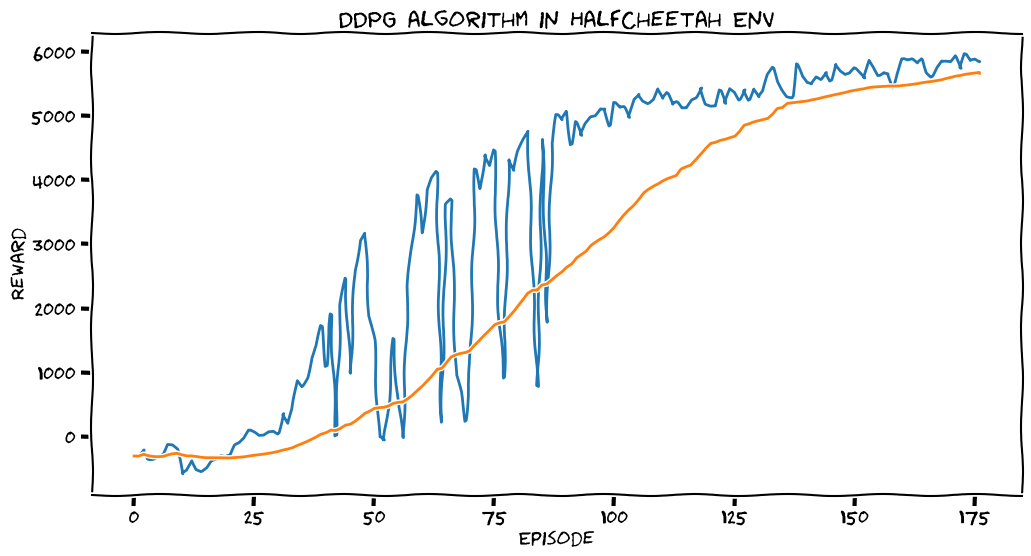

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [13]:
# Training Loop for DDPG
total_numsteps = 0
updates = 0
reward_history = []
eval_reward_history = []
Max_episodes = 500
criteria = 0
max_reward = -float('inf')

for i_episode in range(1, Max_episodes + 1):
    episode_steps = 0
    done = False
    state, _ = env.reset()
    episode_reward = 0

    while not done:
        if total_numsteps < config.get('start_steps', 10000):
            action = env.action_space.sample()  # Random action initially
        else:
            action = agent.select_action(state)  # Action from policy

        if len(memory) > config['batch_size']:
            agent.update_parameters(memory, config['batch_size'], updates)
            updates += 1

        next_state, reward, done, truncated, _ = env.step(action)
        episode_reward += reward
        episode_steps += 1
        total_numsteps += 1

        mask = 1 if episode_steps == env._max_episode_steps else float(not (done or truncated))
        memory.push(state, action, reward, next_state, mask)

        state = next_state
        done = done or truncated

    reward_history.append(episode_reward)

    # Frequent evaluation to closely match training curve
    eval_state, _ = env.reset()
    eval_episode_reward = 0
    eval_done = False

    while not eval_done:
        eval_action = agent.select_action(eval_state)
        eval_next_state, eval_reward, eval_done, eval_truncated, _ = env.step(eval_action)
        eval_episode_reward += eval_reward
        eval_state = eval_next_state
        eval_done = eval_done or eval_truncated

    eval_reward_history.append(eval_episode_reward)

    if i_episode % 10 == 0:
        print(f"Episode: {i_episode}, Train reward: {episode_reward:.2f}, Eval reward: {eval_episode_reward:.2f}")

    if eval_episode_reward > max_reward:
        max_reward = eval_episode_reward
        criteria = 0
    else:
        criteria += 1

    if criteria >= 20:
        print("Early stopping criteria met")
        break

env.close()

# Plot both training and evaluation rewards
plot_rewards(reward_history, show_result='DDPG algorithm in HalfCheetah Env')

In [14]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
state, _ = env.reset()
frames = []

total_reward = 0
done = False
# run the policy in the environment in a loop
while not done:
    frames.append(env.render())
    action  = agent.select_action(state,evaluate=True)
    next_state, reward, done, truncated, _  = env.step(action)
    total_reward += reward
    state = next_state
    done = done or truncated

env.close()
print(f'Total Reward: {total_reward}')

imageio.mimsave('./eval_DDPG.mp4', frames, fps=25)
show_video('./eval_DDPG.mp4')

Total Reward: 5929.454276857936
